In [2]:
import sys
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

sys.path.append("./")
sys.path.append("../")

from sbi import utils
from utils import create_mask as cm
from models.scd import dnds

In [3]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def dnds_conv(s_ary, theta, ps_temp, roi_counts_normalize, roi_normalize):
    dnds_ary = dnds(s_ary, [1] + list(theta[1:]))
    A = theta[0] / np.trapz(s_ary * dnds_ary, s_ary) / np.mean(ps_temp[~roi_counts_normalize]) ** 2 * np.mean(ps_temp[~roi_normalize])
    dnds_ary = dnds(s_ary, [A] + list(theta[1:]))
    return dnds_ary

In [77]:
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
roi_ps_mask = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25, custom_mask=ps_mask), r2n=True)
roi_mask_norm = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25), r2n=True)
roi_normalize = hp.reorder(cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25), r2n=True)
fermi_exp = hp.reorder(np.load("../data/fermi_data/fermidata_exposure.npy"), r2n=True)
fermi_data = hp.reorder(np.load("../data/fermi_data/fermidata_counts.npy"), r2n=True)
s_f_conv = np.mean(fermi_exp[~roi_mask_norm])
pixarea_deg = hp.nside2pixarea(hp.npix2nside(len(fermi_exp)), degrees=True)

In [76]:
# gce, dsk PS priors
prior_ps_usual = [[0., 10.0, 1.1, -10.0, 5.0, 0.1], 
            [2.5, 20.0, 1.99, 1.99, 40.0, 4.99]]

samples = np.random.uniform(prior_ps_usual[0], prior_ps_usual[1], size=(10000, len(prior_ps_usual[0])))

prior_ps_new = [[0.3, 10.0, 1.1, -10.0, 1.0, 0.1], 
            [2.5, 20.0, 1.99, 1.99, 30.0, 0.99]]

samples_new = np.random.uniform(prior_ps_new[0], prior_ps_new[1], size=(10000, len(prior_ps_new[0])))

In [11]:
from utils.templates import get_NFW2_template
roi_normalize_temps = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=30)
temp_gce = get_NFW2_template(gamma=1.2, exp_map=fermi_exp, roi_normalize=roi_normalize_temps)
temp_gce[~roi_normalize_temps].mean()
temp_gce = hp.reorder(temp_gce, r2n=True)

In [19]:
np.cumsum(np.array([dnds_conv(s_ary, samples[i, :], temp_gce, roi_mask_norm, roi_normalize) for i in range(len(samples))]) * (s_f_conv / pixarea_deg), axis=0).shape

(10000, 50)

In [29]:
from scipy.integrate import cumtrapz
cumtrapz(np.array([dnds_conv(s_ary, samples[i, :], temp_gce, roi_mask_norm, roi_normalize) for i in range(len(samples))]), s_ary / s_f_conv, axis=1)

(10000, 49)

In [68]:
fermi_data[~roi_mask_norm]

array([ 6.,  2.,  0., ...,  3.,  5., 12.])

In [87]:
sigma = np.sqrt(np.mean(fermi_data[~roi_ps_mask])) / np.mean(fermi_exp[~roi_normalize])

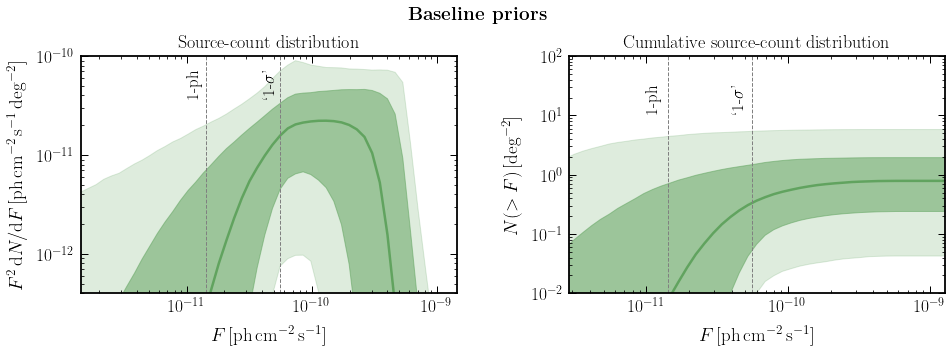

In [124]:
fig, ax = plt.subplots(1, 2, figsize=(13.35, 5.))

s_ary = np.logspace(-1, 2)
dnds_samples = (s_ary / s_f_conv) ** 2 * np.array([dnds_conv(s_ary, samples[i, :], temp_gce, roi_mask_norm, roi_normalize) for i in range(len(samples))]) * (s_f_conv / pixarea_deg)

ax[0].plot(s_ary / s_f_conv, np.median(dnds_samples, axis=0), color=cols_default[2])
ax[0].fill_between(s_ary / s_f_conv, np.percentile(dnds_samples, axis=0, q=[2.5])[0], np.percentile(dnds_samples, axis=0, q=[97.5])[0], alpha=0.2, color=cols_default[2])
ax[0].fill_between(s_ary / s_f_conv, np.percentile(dnds_samples, axis=0, q=[16])[0], np.percentile(dnds_samples, axis=0, q=[84])[0], alpha=0.5, color=cols_default[2])
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlim(1e-1 / s_f_conv, 1e2 / s_f_conv)
ax[0].set_ylim(4e-13, 1e-10)
ax[0].set_ylabel(r"$F^2\,\mathrm{d}N/\mathrm{d}F$\,[ph\,cm$^{-2}$\,s$^{-1}$\,deg$^{-2}$]")
ax[0].set_xlabel(r"$F$\,[ph\,cm$^{-2}$\,s$^{-1}$]")
ax[0].set_title(r"{Source-count distribution}", y=1.008)
ax[0].axvline(1 / s_f_conv, ls='--', color='grey', lw=1, )
ax[0].axvline(sigma, ls='--', color='grey', lw=1, )
ax[0].text(1e-11, 4e-11, "1-ph", rotation=90, fontsize=17)
ax[0].text(4e-11, 4e-11, r"`1-$\sigma$'", rotation=90, fontsize=17)

dnds_cum_samples = cumtrapz(np.array([dnds_conv(s_ary, samples[i, :], temp_gce, roi_mask_norm, roi_normalize) for i in range(len(samples))])  / pixarea_deg, s_ary, axis=1)

s_ary = (s_ary[1:] + s_ary[:-1]) / 2.

ax[1].plot(s_ary / s_f_conv, np.median(dnds_cum_samples, axis=0), color=cols_default[2])
ax[1].fill_between(s_ary / s_f_conv, np.percentile(dnds_cum_samples, axis=0, q=[2.5])[0], np.percentile(dnds_cum_samples, axis=0, q=[97.5])[0], alpha=0.2, color=cols_default[2])
ax[1].fill_between(s_ary / s_f_conv, np.percentile(dnds_cum_samples, axis=0, q=[16])[0], np.percentile(dnds_cum_samples, axis=0, q=[84])[0], alpha=0.5, color=cols_default[2])
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlim(2e-1 / s_f_conv, 0.9 * 1e2 / s_f_conv)
ax[1].set_ylim(1e-2, 1e2)
ax[1].set_ylabel(r"$N(>F)$\,[deg$^{-2}$]")
ax[1].set_xlabel(r"$F$\,[ph\,cm$^{-2}$\,s$^{-1}$]")
ax[1].set_title(r"{Cumulative source-count distribution}", y=1.008)
ax[1].axvline(1 / s_f_conv, ls='--', color='grey', lw=1, )
ax[1].axvline(sigma, ls='--', color='grey', lw=1, )
ax[1].text(1e-11, 12, "1-ph", rotation=90, fontsize=17)
ax[1].text(4e-11, 12, r"`1-$\sigma$'", rotation=90, fontsize=17)

plt.suptitle(r"\bf{Baseline priors}", y=0.97, fontsize=19)

plt.tight_layout()
fig.subplots_adjust(wspace=0.3)
plt.savefig("../paper/plots/pp_check_baseline.pdf")

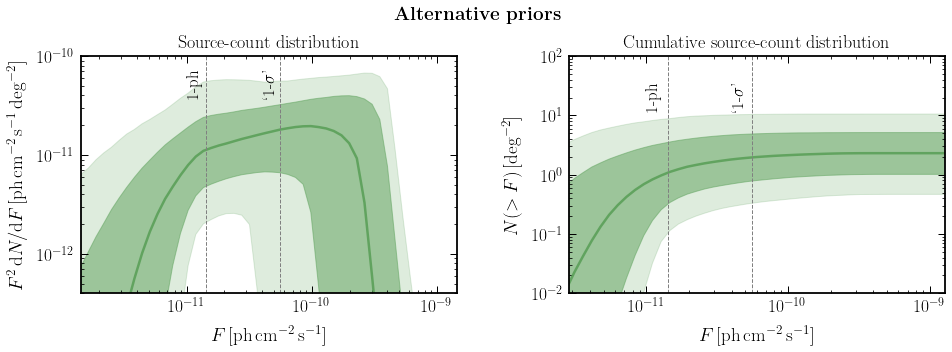

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(13.35, 5.))

s_ary = np.logspace(-1, 2)
dnds_samples = (s_ary / s_f_conv) ** 2 * np.array([dnds_conv(s_ary, samples_new[i, :], temp_gce, roi_mask_norm, roi_normalize) for i in range(len(samples))]) * (s_f_conv / pixarea_deg)

ax[0].plot(s_ary / s_f_conv, np.median(dnds_samples, axis=0), color=cols_default[2])
ax[0].fill_between(s_ary / s_f_conv, np.percentile(dnds_samples, axis=0, q=[2.5])[0], np.percentile(dnds_samples, axis=0, q=[97.5])[0], alpha=0.2, color=cols_default[2])
ax[0].fill_between(s_ary / s_f_conv, np.percentile(dnds_samples, axis=0, q=[16])[0], np.percentile(dnds_samples, axis=0, q=[84])[0], alpha=0.5, color=cols_default[2])
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlim(1e-1 / s_f_conv, 1e2 / s_f_conv)
ax[0].set_ylim(4e-13, 1e-10)
ax[0].set_ylabel(r"$F^2\,\mathrm{d}N/\mathrm{d}F$\,[ph\,cm$^{-2}$\,s$^{-1}$\,deg$^{-2}$]")
ax[0].set_xlabel(r"$F$\,[ph\,cm$^{-2}$\,s$^{-1}$]")
ax[0].set_title(r"{Source-count distribution}", y=1.008)
ax[0].axvline(1 / s_f_conv, ls='--', color='grey', lw=1, )
ax[0].axvline(sigma, ls='--', color='grey', lw=1, )
ax[0].text(1e-11, 4e-11, "1-ph", rotation=90, fontsize=17)
ax[0].text(4e-11, 4e-11, r"`1-$\sigma$'", rotation=90, fontsize=17)

dnds_cum_samples = cumtrapz(np.array([dnds_conv(s_ary, samples_new[i, :], temp_gce, roi_mask_norm, roi_normalize) for i in range(len(samples))])  / pixarea_deg, s_ary, axis=1)

s_ary = (s_ary[1:] + s_ary[:-1]) / 2.

ax[1].plot(s_ary / s_f_conv, np.median(dnds_cum_samples, axis=0), color=cols_default[2])
ax[1].fill_between(s_ary / s_f_conv, np.percentile(dnds_cum_samples, axis=0, q=[2.5])[0], np.percentile(dnds_cum_samples, axis=0, q=[97.5])[0], alpha=0.2, color=cols_default[2])
ax[1].fill_between(s_ary / s_f_conv, np.percentile(dnds_cum_samples, axis=0, q=[16])[0], np.percentile(dnds_cum_samples, axis=0, q=[84])[0], alpha=0.5, color=cols_default[2])
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlim(2e-1 / s_f_conv, 0.9 * 1e2 / s_f_conv)
ax[1].set_ylim(1e-2, 1e2)
ax[1].set_ylabel(r"$N(>F)$\,[deg$^{-2}$]")
ax[1].set_xlabel(r"$F$\,[ph\,cm$^{-2}$\,s$^{-1}$]")
ax[1].set_title(r"{Cumulative source-count distribution}", y=1.008)
ax[1].axvline(1 / s_f_conv, ls='--', color='grey', lw=1, )
ax[1].axvline(sigma, ls='--', color='grey', lw=1, )
ax[1].text(1e-11, 13, "1-ph", rotation=90, fontsize=17)
ax[1].text(4e-11, 13, r"`1-$\sigma$'", rotation=90, fontsize=17)

plt.suptitle(r"\bf{Alternative priors}", y=0.97, fontsize=19)

plt.tight_layout()
fig.subplots_adjust(wspace=0.3)
plt.savefig("../paper/plots/pp_check_alt.pdf")